In [1]:
import utils
import qiskit
import qiskit_aer
import numpy as np
from math import log
import qiskit.visualization
import matplotlib.pyplot as plt
from qiskit.circuit.library.standard_gates import RYGate

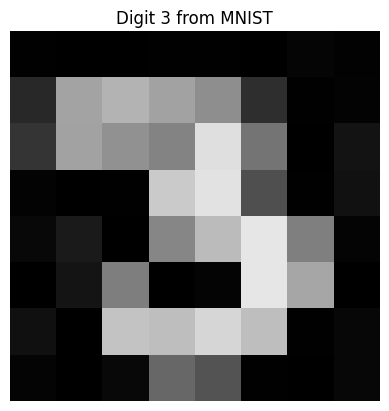

In [2]:
image = utils.plot_image('../images/three_8by8.jpg', 'Digit 3 from MNIST')

In [3]:
def equal_superposition(circ: qiskit.QuantumCircuit, start: int, end: int):
    circ.h([*range(start, end)])
        
def iterate(circ: qiskit.QuantumCircuit, padding: int, current_state: str, next_state: str):
    n = len(current_state)
    
    x_targets = np.array([idx + padding for idx in range(n) 
                          if current_state[idx] != next_state[idx]])
    
    if x_targets.size > 0:
        circ.x(x_targets)

def pixel_encoding(circ: qiskit.QuantumCircuit, control: list, target: int, intensity: float):
    # Making the C^nRY manually improves visualization
    cry = RYGate(2 * intensity).control(len(control))
    aux = np.append(control, target).tolist()
    circ.append(cry, aux)

In [4]:
im_list = image.flatten()
# theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

In [5]:
num_ind_bits = int(np.ceil(log(len(im_list),2)))
sorted_position_reg = qiskit.QuantumRegister(num_ind_bits, 'sorted_position') # Sorted coordinate (by intensity)
color_reg = qiskit.QuantumRegister(1,'color')  # Color
spatial_position_reg = qiskit.QuantumRegister(1, 'spatial_position') 
cr = qiskit.ClassicalRegister(num_ind_bits + 1 + 1, "bits")

In [6]:
controls = list(spatial_position_reg) + list(sorted_position_reg)

In [7]:
def construct_oqim(circ: qiskit.QuantumCircuit, phis, thetas):
    num_qubits = circ.num_qubits
    equal_superposition(circ, 1, num_qubits)
    
    for i, (phi, theta) in enumerate(zip(phis, thetas)):
        state = '{0:0{1}b}'.format(i-1, num_ind_bits) 
        next_state = '{0:0{1}b}'.format(i, num_ind_bits)

        if i > 0:
            iterate(circ, 2, state, next_state)
            
        # Pixel encoding
        pixel_encoding(circ, controls, color_reg, theta)
        circ.x(spatial_position_reg)
        pixel_encoding(circ, controls, color_reg, phi)

        if i < len(thetas) - 1:
            circ.x(spatial_position_reg)

        circ.barrier()
    
    to_measure = [*range(num_qubits)]        
    circ.measure(reversed(to_measure), to_measure) 

In [8]:
oqim_circ = qiskit.QuantumCircuit(color_reg, spatial_position_reg, sorted_position_reg, cr)

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


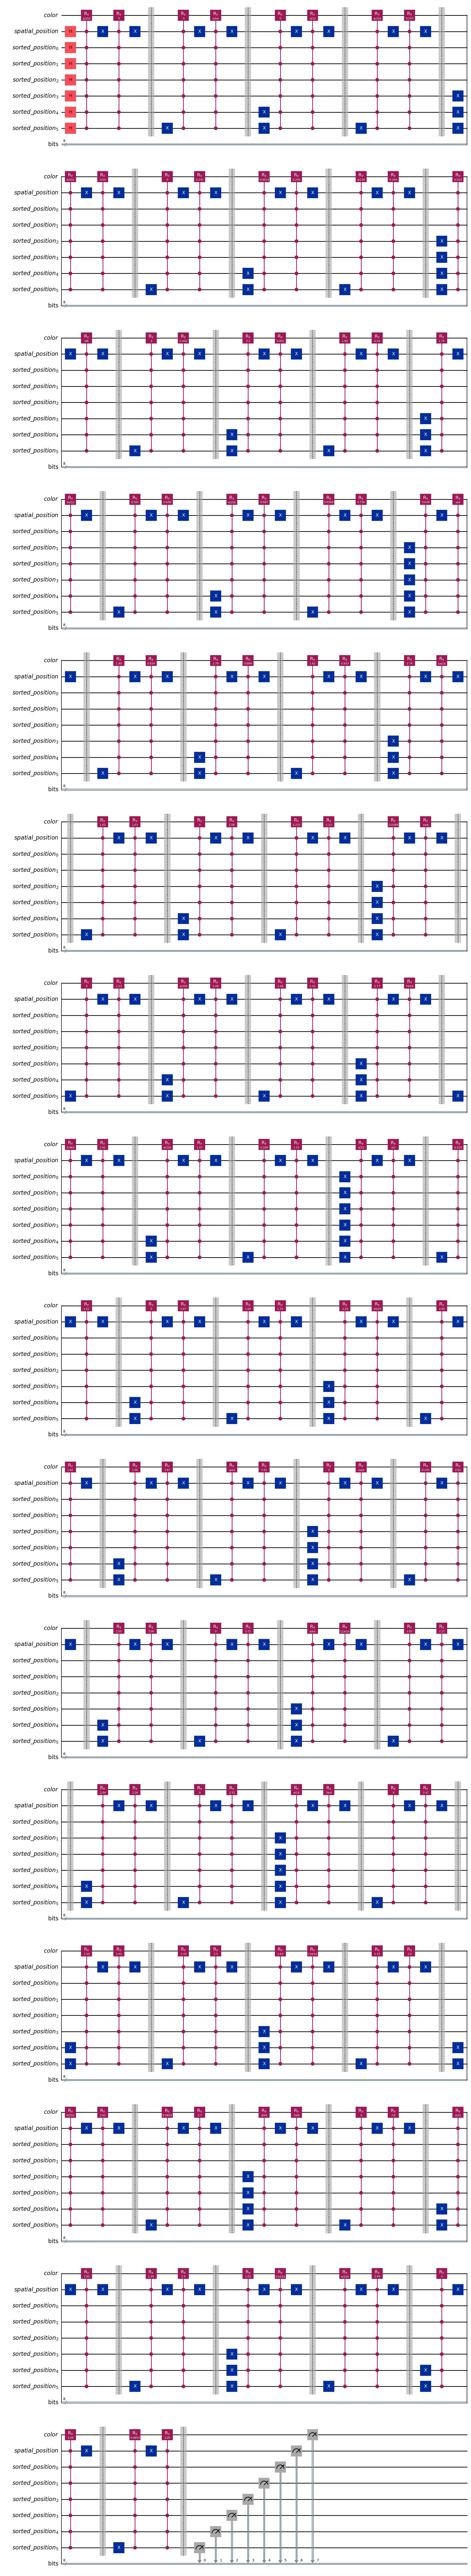

In [9]:
construct_oqim(oqim_circ, phis, thetas)
oqim_circ.draw(output='mpl')

In [10]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(oqim_circ, simulator)
shots = 10000
result = simulator.run(circuit, shots=shots).result()

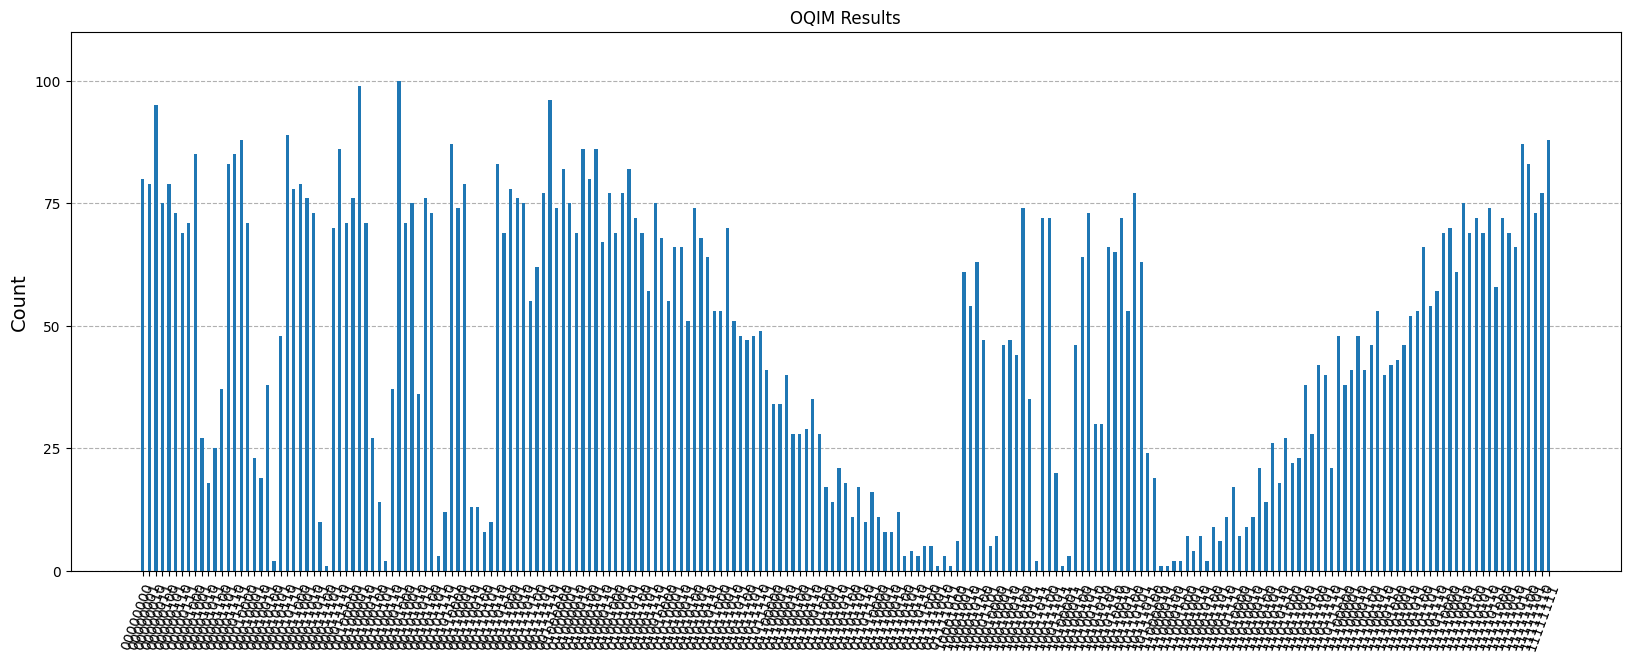

In [11]:
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(20, 7), title="OQIM Results", bar_labels=False)

In [12]:
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)

In [13]:
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]): # only difference
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
output_im = classical_colors.reshape(image.shape)

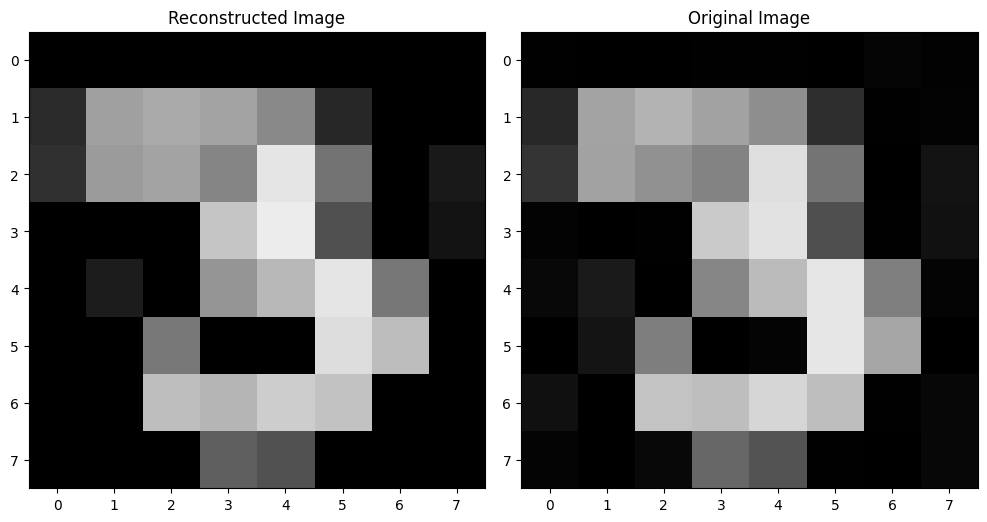

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_im, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Reconstructed Image')
axs[1].imshow(image, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Original Image')

plt.tight_layout()